# Collect Data

In [ ]:
from coletor import collect_data
import os
from time import sleep
collect_data()
sleep(1)
os.system(r'''taskkill /IM terminal64.exe''')

# Get previsions

In [9]:
import os
os.system(r'''matlab.exe -nosplash -nodesktop -batch "cd C:\Users\gubar\Documents\UFMG\TCC\; try, run ('C:\Users\gubar\Documents\UFMG\TCC\matlab\main.m'); end; quit"''')
# os.system(r'''matlab.exe -r "cd C:\Users\gubar\Documents\UFMG\TCC\; try, run ('C:\Users\gubar\Documents\UFMG\TCC\matlab\main.m'); end;"''')

0

# Run Backtests

In [1]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np

m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")
d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/previsions/*D1.csv")


alavancagem = 2

def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain, alavancagem = teste
    trader = Trader(stop, gain)
    trader.leverage = alavancagem
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "df_orders_summary": df_orders_summary,
        "df_orders_original": df_orders_original,
        "stop": stop, 
        "gain": gain
    }

iterable = []

for index, m15_file in enumerate(m15_files):
    # if m15_file.split("/data\\")[1].split("_")[0] != "WDO":
    #     continue
    df_d1     = pd.read_csv(d1_files[index])
    df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

    df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
    df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

    df_m15 = pd.read_csv(m15_file)
    df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
    iterable.append((df_m15, df_d1, m15_file, 0.25, 0.85, alavancagem))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)


# Distribuição resultados

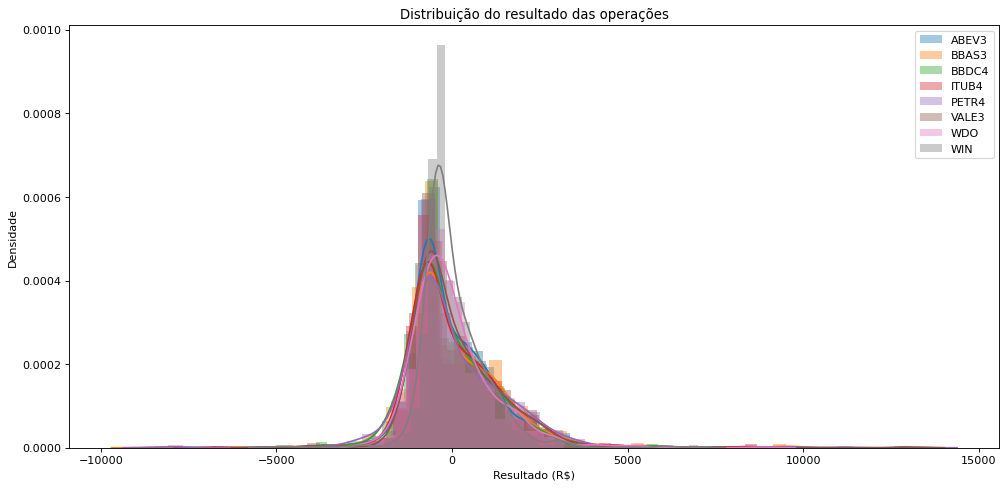

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,7), dpi= 80)

for item in dfs_orders_summary:
    sns.distplot(item["df_orders_summary"]["result"], label=item["stock_code"])
plt.legend()
plt.title("Distribuição do resultado das operações")
plt.xlabel("Resultado (R$)")
plt.ylabel("Densidade")
plt.savefig(f'../results/distribuição_resultados.png')

# Resultado linhas

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_width = 1184 * 1.2
pio.kaleido.scope.default_height = 450 * 1.2
fig = go.Figure()
for item in dfs_orders_summary:
    fig.add_trace(go.Scatter(x=item["df_orders_summary"]["time"], y=item["df_orders_summary"]["cum_result"],
                        mode='lines',
                        name=item["stock_code"]))
# fig.update_layout(yaxis_range=[0,150000000000e3])
fig.update_yaxes(rangemode="tozero")


fig.update_layout(
    title="Resultado ao longo do tempo",
    xaxis=dict(
        title="Data"
    ),
    yaxis=dict(
        title="Resultado (R$)"
    ) 
    
)
fig.show()
fig.write_image("../results/resultados.png")




# Cálculo Métricas

In [4]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.35, 0.8)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "annualized_returns": annualized
    })

df_metrics_results = pd.DataFrame(metrics_results)
teste = df_metrics_results.agg(['mean', 'std']).reset_index()
teste = teste.rename(columns={'index': 'stock_code'})
df_metrics_results = pd.concat([df_metrics_results,teste]).reset_index(drop=True)

In [5]:
# df_metrics_results.to_latex(f"../results/capital_inicial_{alavancagem}x_alavancado.tex", index=False)
display(df_metrics_results)

,stock_code,maximum_drawdown,maximum_drawdown_percentage,rate,annualized_returns
0,ABEV3,-39392.631360,-71.504171,41.158537,-15.798896
1,BBAS3,-27471.035131,-52.837758,41.297935,12.143732
2,BBDC4,-42316.645302,-79.479518,39.450867,-30.131580
3,ITUB4,-25042.247166,-28.700972,42.372881,24.662274
4,PETR4,-25069.158347,-30.765030,39.577465,19.477753
5,VALE3,-22593.989907,-38.044675,41.369048,23.884229
6,WDO,-16399.354000,-29.555308,40.476190,12.890253
7,WIN,-12725.122700,-22.179462,40.851064,22.818480
8,mean,-26376.272989,-44.133362,40.819248,8.743281
9,std,10200.883817,21.456650,0.970531,20.488103


# Contorno do stop gain

In [ ]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np
m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")
d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/previsions/*D1.csv")


def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain = teste
    trader = Trader(stop, gain)
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "df_orders_summary": df_orders_summary,
        "stop": stop, 
        "gain": gain
    }

iterable = []
stops = [
    (0.45, 0.5),
    (0.15, 0.75),
    (0.2, 0.9),
    (0.2, 0.75),
    (0.15, 0.9)
]
for stop in np.arange(0.1, 0.6, 0.05):
    for gain in np.arange(0.5, 1.05, 0.05):
# for stop, gain in stops:
        for index, m15_file in enumerate(m15_files):
            # if m15_file.split("/data\\")[1].split("_")[0] == "MGLU3":
            #     continue
            if m15_file.split("/data\\")[1].split("_")[0] not in ["VALE3", "PETR4", "WIN", "WDO"]:
                continue
            df_d1     = pd.read_csv(d1_files[index])
            df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

            df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
            df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

            df_m15 = pd.read_csv(m15_file)
            df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
            iterable.append((df_m15, df_d1, m15_file, stop, gain))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)



In [ ]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.20, 0.60)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "gain": item["gain"],
        "stop": item["stop"],
        "annualized_returns": annualized
    })

pd.DataFrame(metrics_results).sort_values(by=['stock_code', 'annualized_returns'], ascending=False)
df_metrics_results = pd.DataFrame(metrics_results)

In [ ]:
df_metrics_results.to_csv("../results/stop_take_metrics_results.csv")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df_metrics_results = pd.read_csv("../results/stop_take_metrics_results.csv")

for stock in ["VALE3", "PETR4", "WIN", "WDO"]:
    
    fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150)
    fig.tight_layout(pad=3.0)
    fig.suptitle(f"Otimização Stop-Loss/Take-Profit ({stock})")

    df_metrics_results["gain"] = round(df_metrics_results["gain"], 2)
    df_metrics_results["stop"] = round(df_metrics_results["stop"], 2)

    df_heatmap = df_metrics_results[df_metrics_results["stock_code"] == stock][["stop", "gain", "annualized_returns"]]
    df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='annualized_returns')
    ax = sns.heatmap(df_heatmap, ax = axes[0])
    ax.title.set_text('Retorno Anualizado')
    ax.set_ylabel('Stop-Loss')
    ax.set_xlabel('Take-Profit')

    ax.tick_params(labelrotation=45)


    df_heatmap = df_metrics_results[df_metrics_results["stock_code"] == stock][["stop", "gain", "maximum_drawdown_percentage"]]
    df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='maximum_drawdown_percentage')
    ax = sns.heatmap(df_heatmap, ax = axes[1])
    ax.title.set_text('Drawdown Máximo')
    ax.tick_params(labelrotation=45)
    ax.set_ylabel('Stop-Loss')
    ax.set_xlabel('Take-Profit')

    # plt.savefig(f'../results/stop_loss_take_profit_{stock}.png')

In [ ]:
df_metrics_results_group = df_metrics_results[["gain", "stop", "maximum_drawdown_percentage", "annualized_returns"]].groupby(["gain", "stop"]).mean()

fig, axes = plt.subplots(1, 2, figsize=(12,5), dpi=150)
fig.tight_layout(pad=3.0)
fig.suptitle(f"Média resultados otimização Stop-Loss/Take-Profit")

df_metrics_results["gain"] = round(df_metrics_results["gain"], 2)
df_metrics_results["stop"] = round(df_metrics_results["stop"], 2)

df_heatmap = df_metrics_results_group.reset_index()
df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='annualized_returns')
ax = sns.heatmap(df_heatmap, ax = axes[0], annot=True)
ax.title.set_text('Retorno Anualizado (%)')
ax.set_ylabel('Stop-Loss')
ax.set_xlabel('Take-Profit')

ax.tick_params(labelrotation=45)


df_heatmap = df_metrics_results_group.reset_index()
df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='maximum_drawdown_percentage')
ax = sns.heatmap(df_heatmap, ax = axes[1], annot=True)
ax.title.set_text('Drawdown Máximo (%)')
ax.tick_params(labelrotation=45)
ax.set_ylabel('Stop-Loss')
ax.set_xlabel('Take-Profit')
plt.savefig(f'../results/stop_loss_take_profit_mean.png')

In [ ]:
df_metrics_results_group.reset_index()

# Analyse results

In [80]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

df_plot = filter(lambda item: item["stock_code"] == "PETR4", dfs_orders_summary)
df_plot = list(df_plot)[0]["df_orders_original"].copy()
df_plot = df_plot[df_plot["time"] > datetime(2021, 1, 1)].reset_index()
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


df_plot['order_nature'] = df_plot['order_nature'].replace("buy_signal", 'triangle-up')
df_plot['order_nature'] = df_plot['order_nature'].replace("sell_signal", 'triangle-down')
df_plot['order_nature'] = df_plot['order_nature'].replace("take_profit", 'arrow-bar-up')
df_plot['order_nature'] = df_plot['order_nature'].replace("stop_loss", 'arrow-bar-down')
df_plot['order_nature'] = df_plot['order_nature'].replace("last_candle", 'arrow-bar-right')
df_plot['order_nature'] = df_plot['order_nature'].replace("", 100)

df_d1 = pd.read_csv("../data/PETR4_D1.csv")

fig = px.line(df_plot, x="time", y=["min_ann", "max_ann", "close"])
fig.add_trace(go.Scatter(x=df_plot["time"], y=abs(df_plot["order"]),
    mode='markers',
    name='markers',
    marker=dict(
        size=14,
        # I want the color to be green if 
        # lower_limit ≤ y ≤ upper_limit
        # else red
        symbol=df_plot["order_nature"],
        line=dict(
            width=2
        ),
        color=(
            (df_plot["order"] > 0)
        ).astype('int'),
        colorscale=[[0, 'red'], [1, 'green']],
    )
))

df_d1["time"] =  pd.to_datetime(df_d1['time'], unit='s') + timedelta(hours = 10)

fig.add_trace(go.Scatter(x=df_d1["time"], y=abs(df_d1["open"]),
    mode='lines',
))

fig.add_trace(go.Scatter(x=df_d1["time"], y=abs(df_d1["low"]),
    mode='lines',
))

fig.add_trace(go.Scatter(x=df_d1["time"], y=abs(df_d1["high"]),
    mode='lines',
))
fig.update_layout(
    title="Operações em PETR4",
    xaxis=dict(
        title="Data"
    ),
    yaxis=dict(
        title="Preço (R$)"
    ) 
    
)
fig.show()

,order,order_nature,min_ann,max_ann,time,close,cum_result,contracts,exit_order,exit_price,exit_order_nature,result,hour,minute
0,19.951995,buy_signal,20.027993,20.407582,2019-01-21 10:30:00,19.95,51578.681736,5012.0,2019-01-21 18:00:00,-20.267973,last_candle,1583.681736,10,30
1,20.062006,buy_signal,20.070871,20.313904,2019-01-28 12:00:00,20.06,50756.161676,4985.0,2019-01-28 12:30:00,-19.898010,stop_loss,-817.520060,12,0
3,-20.677932,sell_signal,20.217072,20.611166,2019-02-04 15:45:00,20.68,50206.114296,4835.0,2019-02-04 18:00:00,20.672067,last_candle,28.357275,15,45
6,19.841984,buy_signal,20.070273,20.405235,2019-02-07 14:30:00,19.84,50266.699612,5040.0,2019-02-07 14:45:00,-19.748025,stop_loss,-473.553360,14,30
10,-20.937906,sell_signal,20.443871,20.891341,2019-02-14 15:00:00,20.94,48096.565145,4775.0,2019-02-14 15:30:00,21.092109,stop_loss,-736.319325,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,28.482848,buy_signal,28.508125,29.280490,2021-12-29 14:15:00,28.48,102082.629119,3511.0,2021-12-29 17:45:00,-28.537146,last_candle,190.640278,14,15
647,29.032903,buy_signal,29.032197,29.674976,2022-01-05 10:45:00,29.03,100024.387318,3444.0,2022-01-05 11:00:00,-28.737126,stop_loss,-1018.655988,10,45
649,27.932793,buy_signal,28.047518,28.384474,2022-01-11 10:30:00,27.93,100167.222918,3580.0,2022-01-11 12:00:00,-28.247175,take_profit,1125.487560,10,30
650,-28.437156,sell_signal,28.047518,28.384474,2022-01-11 12:15:00,28.44,99333.463042,3516.0,2022-01-11 13:00:00,28.672867,stop_loss,-828.759876,12,15


<AxesSubplot:>

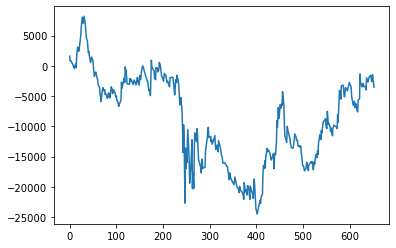

In [48]:
import numpy as np
df_test = filter(lambda item: item["stock_code"] == "PETR4", dfs_orders_summary)
df_test = list(df_test)[0]["df_orders_summary"].copy()
df_test["hour"] = df_test["time"].dt.hour 
df_test["minute"] =   df_test["time"].dt.minute

df_test = df_test[(df_test["hour"] != 10) | (df_test["minute"] != 0)]
display(df_test)

df_test["result"].cumsum().plot()



In [85]:
max_ann = 25.71
min_ann = 25.67

alvo_percentage = 100 * (max_ann - min_ann) / max_ann

slippage_percentage = 0.1
slippage_preco = max_ann * slippage_percentage/100

print("alvo_percentage:",alvo_percentage)
print("slippage_percentage:",slippage_percentage)
print("slippage_preco:",slippage_preco)

print((1/alvo_percentage) * (max_ann - min_ann))
if alvo_percentage < 2 * slippage_percentage:
    print("nao posso")

alvo_percentage: 0.1555814858031861
slippage_percentage: 0.1
slippage_preco: 0.02571
0.25710000000000005
nao posso


In [86]:
df_plot = filter(lambda item: item["stock_code"] == "PETR4", dfs_orders_summary)
df_plot = list(df_plot)[0]
df_plot

{'stock_code': 'PETR4',
 'df_orders_summary':          order order_nature    min_ann    max_ann                time  close  \
 0    20.132013   buy_signal  20.154572  20.330795 2019-01-21 10:00:00  20.13   
 1    20.152015   buy_signal  20.154572  20.330795 2019-01-21 16:30:00  20.15   
 2    19.961996   buy_signal  19.964355  20.256114 2019-01-22 16:00:00  19.96   
 3   -20.237976  sell_signal  19.943417  20.206370 2019-01-28 10:15:00  20.24   
 4    19.901990   buy_signal  19.943417  20.206370 2019-01-28 12:45:00  19.90   
 ..         ...          ...        ...        ...                 ...    ...   
 704 -29.407059  sell_signal  28.027486  29.311029 2022-01-12 10:00:00  29.41   
 705  29.622962   buy_signal  29.749323  30.682610 2022-01-13 10:00:00  29.62   
 706 -31.296870  sell_signal  29.998499  31.255228 2022-01-14 15:30:00  31.30   
 707 -31.886811  sell_signal  31.616197  31.854988 2022-01-18 10:15:00  31.89   
 708  31.403140   buy_signal  31.616197  31.854988 2022-01-18 14

In [ ]:
from IPython.core.display import display, HTML

for item in dfs_orders_summary:
    if (item["stock_code"] != "WDO"):
        continue
    df_orders_summary = item["df_orders_summary"]
    display(HTML(df_orders_summary.to_html()))


# Benchs

In [7]:
from benchmark import Benchmark
benchmark = Benchmark()
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np

from datetime import datetime, timedelta
import numpy as np
import pandas as pd


import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*D1.csv")
print(d1_files)

prevision_results = []

def erro (ys ,ydv):
    erro2 = 100 * abs((ydv-ys)/ydv);
    return sum(erro2) / len(ydv)

def calc_acerto (ys ,ydv):
    acerto = 0
    for k in range(2, len(ydv)):
        aux=(ys[k]-ys[k-1])*(ydv[k]-ydv[k-1]);
        if aux>=0:
            acerto=acerto+1;
    return acerto*100/len(ydv)

for index, d1_file in enumerate(d1_files):
    df_d1 = pd.read_csv(d1_files[index])
    # mma = benchmark.mma(df_d1, 5)
    print(d1_files[index])
    for bench, func in [
            ("MMS-5", benchmark.sma_5),
            ("MMS-10", benchmark.sma_10),
            ("MMS-20", benchmark.sma_20),
            ("one-day-lag", benchmark.one_day_lag)
        ]:
        
        df_prevision_data = func(df_d1)
        


        mape_low = erro(df_prevision_data["low"], df_prevision_data["min_ann"])
        mape_high = erro(df_prevision_data["high"], df_prevision_data["max_ann"])

        acerto_low = calc_acerto(df_prevision_data["low"], df_prevision_data["min_ann"])
        acerto_high = calc_acerto(df_prevision_data["high"], df_prevision_data["max_ann"])

        stock = d1_file.split("\\")[1].split(".")[0]

        df_prevision_data[["time", "min_ann", "max_ann", "real_volume"]].to_csv(f'../{bench}/{stock}.csv', header=False, index=False)

        prevision_results.append({
            "benchmark": bench,
            "epm_min": mape_low,
            "epm_max": mape_high,
            "acerto_min": acerto_low,
            "acerto_max": acerto_high,
        })
        df_prevision_data["time"] = pd.to_datetime(df_prevision_data["time"], unit="s")
        fig = px.line(df_prevision_data, x="time", y=["high", "max_ann", "low", "min_ann"])
        

fig.show()

benchmark_df = pd.DataFrame(prevision_results).groupby(["benchmark"]).agg(['mean', 'std']).reset_index()
display(benchmark_df)
benchmark_df.to_latex("../results/benchmark.tex", index=False, float_format="{:0.2f}".format)






['C:/Users/gubar/Documents/UFMG/TCC/data\\ABEV3_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\BBAS3_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\BBDC4_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\ITUB4_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\PETR4_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\VALE3_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\WDO_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\WIN_D1.csv']
C:/Users/gubar/Documents/UFMG/TCC/data\ABEV3_D1.csv
C:/Users/gubar/Documents/UFMG/TCC/data\BBAS3_D1.csv
C:/Users/gubar/Documents/UFMG/TCC/data\BBDC4_D1.csv
C:/Users/gubar/Documents/UFMG/TCC/data\ITUB4_D1.csv
C:/Users/gubar/Documents/UFMG/TCC/data\PETR4_D1.csv
C:/Users/gubar/Documents/UFMG/TCC/data\VALE3_D1.csv
C:/Users/gubar/Documents/UFMG/TCC/data\WDO_D1.csv
C:/Users/gubar/Documents/UFMG/TCC/data\WIN_D1.csv


benchmark   epm_min             epm_max           acerto_min            \
                    mean       std      mean       std       mean       std   
0       MMS-10  2.851583  0.825803  2.726026  0.761397  52.698056  1.561801   
1       MMS-20  4.091452  1.203252  3.939043  1.125193  53.205193  0.993320   
2        MMS-5  2.103774  0.597046  1.993603  0.537065  52.174605  1.248715   
3  one-day-lag  1.312998  0.378978  1.245995  0.342168  54.203732  1.009995   

  acerto_max            
        mean       std  
0  52.704603  2.235470  
1  52.543041  1.415384  
2  52.225453  1.255994  
3  53.467029  0.875230

In [8]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np

m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")

# d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/MMS-5/*D1.csv")
d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/one-day-lag/*D1.csv")
d1_files = d1_files + glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/MMS-5/*D1.csv")
d1_files = d1_files + glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/MMS-10/*D1.csv")
d1_files = d1_files + glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/MMS-20/*D1.csv")

alavancagem = 2

def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain, alavancagem, d1_file = teste
    trader = Trader(stop, gain)
    trader.leverage = alavancagem
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "benchmark": d1_file.split("/")[6].split("\\")[0],
        "df_orders_summary": df_orders_summary,
        "stop": stop, 
        "gain": gain,

    }

iterable = []

for index, m15_file in enumerate(m15_files):

    stock_code = m15_file.split("/data\\")[1].split("_")[0]
    stock_files = filter(lambda d1_file: stock_code in d1_file , d1_files) 

    for j, d1_file in enumerate(stock_files):
        # if m15_file.split("/data\\")[1].split("_")[0] != "WDO":
        #     continue
        df_d1     = pd.read_csv(d1_file)
        df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

        df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
        df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

        df_m15 = pd.read_csv(m15_file)
        df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
        iterable.append((df_m15, df_d1, m15_file, 0.25, 0.85, alavancagem, d1_file))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)


In [15]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.35, 0.8)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "annualized_returns": annualized,
        "benchmark": item["benchmark"]
    })

df_metrics_results = pd.DataFrame(metrics_results)
# display(df_metrics_results)
teste = df_metrics_results.groupby(["benchmark"]).agg(['mean', 'std']).reset_index()
teste = teste.rename(columns={'index': 'stock_code'})

df_metrics_results = pd.concat([df_metrics_results,teste]).reset_index(drop=True)
teste[["benchmark", "maximum_drawdown_percentage", "rate", "annualized_returns"]]

teste[["benchmark", "maximum_drawdown_percentage", "rate", "annualized_returns"]].to_latex(f"../results/negociador_benchmark.tex", index=False, float_format="{:0.2f}".format)

c:\Users\gubar\Documents\UFMG\TCC\src\metrics.py:17: RuntimeWarning:

invalid value encountered in double_scalars

